In [5]:
# Import necessary libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Check if a GPU is available
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found. Make sure TensorFlow is configured to use GPU.")

# Load a pre-trained VGG19 model
base_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet')



GPU found
80134624/80134624 [==============================] - 0s 0us/step


Iteration 0, Total loss: 336.8936462402344
Iteration 100, Total loss: 336.8857421875


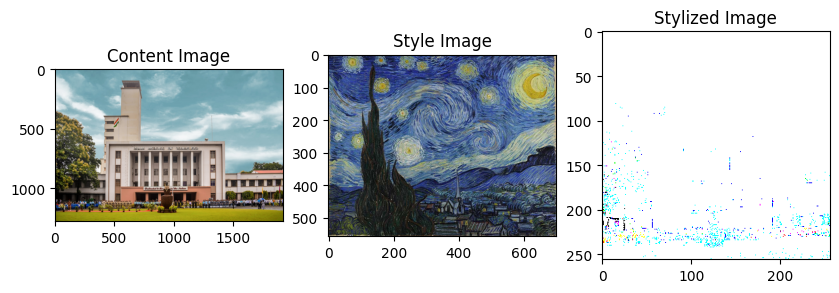

In [53]:
# Create a custom model that extracts features from intermediate layers
style_layers = ['block1_conv1', 'block1_conv2', 'block2_conv1', 'block3_conv1', 'block3_conv3']
content_layer = 'block1_conv1'

style_outputs = [base_model.get_layer(name).output for name in style_layers]
content_output = base_model.get_layer(content_layer).output

model = models.Model(inputs=base_model.input, outputs=style_outputs + [content_output])

# Define a function to calculate the content loss
def get_content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

# Define a function to calculate the Gram matrix (used for style loss)
def gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

# Define a function to calculate the style loss
def get_style_loss(base_style, gram_target):
    height, width, channels = base_style.get_shape().as_list()
    gram_style = gram_matrix(base_style)
    return tf.reduce_mean(tf.square(gram_style - gram_target))

# Define a function to apply style transfer
def apply_style_transfer(content_image, style_image, num_iterations=200, content_weight=1e6, style_weight=1e-7):
    content_image = tf.keras.preprocessing.image.img_to_array(content_image)
    content_image = tf.image.convert_image_dtype(content_image, dtype=tf.uint8)

    style_image = tf.keras.preprocessing.image.img_to_array(style_image)
    style_image = tf.image.convert_image_dtype(style_image, dtype=tf.uint8)

    content_image = tf.image.resize(content_image, (256, 256))
    style_image = tf.image.resize(style_image, (256, 256))

    content_image = tf.expand_dims(content_image, 0)
    style_image = tf.expand_dims(style_image, 0)

    content_image = tf.keras.applications.vgg19.preprocess_input(content_image)
    style_image = tf.keras.applications.vgg19.preprocess_input(style_image)

    generated_image = tf.Variable(content_image, dtype=tf.float32)

    opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

    style_outputs = model(style_image)
    style_features = [style_layer[0] for style_layer in style_outputs[:-1]]
    gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

    for i in range(num_iterations):
        with tf.GradientTape() as tape:
            model_outputs = model(generated_image)
            style_features = model_outputs[:-1]
            content_feature = model_outputs[-1]

            content_loss = get_content_loss(content_feature, model(content_image)[-1])

            style_loss = 0
            for j in range(len(style_layers)):
                style_loss += get_style_loss(style_features[j][0], gram_style_features[j])

            total_loss = content_weight * content_loss + style_weight * style_loss

        grads = tape.gradient(total_loss, generated_image)
        opt.apply_gradients([(grads, generated_image)])

        if i % 100 == 0:
            print(f"Iteration {i}, Total loss: {total_loss.numpy()}")

    return generated_image.numpy()

# Example usage
content_path = '/content/iit_kgp.jpg'
style_path = '/content/Vincent-van-Gogh-starry-Night.jpg'
content_img = image.load_img(content_path)
style_img = image.load_img(style_path)

result = apply_style_transfer(content_img, style_img)
#result = np.clip(result[0], 0, 1)

# Display the results
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(content_img)
plt.title('Content Image')

plt.subplot(1, 3, 2)
plt.imshow(style_img)
plt.title('Style Image')

plt.subplot(1, 3, 3)
plt.imshow(result[0])
plt.title('Stylized Image')

plt.show()

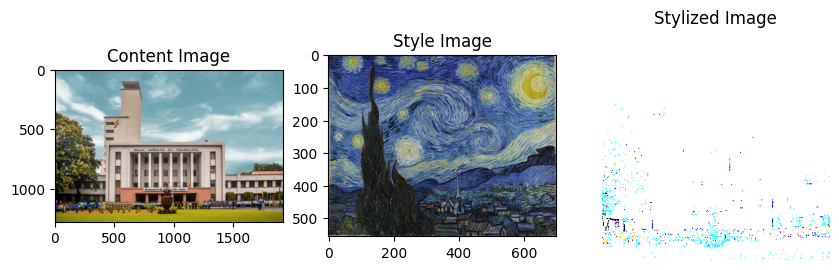

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [55]:

output_filename = 'stylized_image202.jpg'
output_path = '/content/' + output_filename
tf.keras.preprocessing.image.save_img(output_path, result[0])